In [2]:
# 加载并处理数据
import numpy as np

import mindspore as ms
from mindspore import nn
from mindspore import context

# 使用昇腾
context.set_context(mode=context.GRAPH_MODE, device_target="Ascend")
from mindvision.dataset import Mnist

# 下载并处理MNIST数据集
download_train = Mnist(path="./mnist", split="train", batch_size=32, repeat_num=1, shuffle=True, resize=32, download=True)

download_eval = Mnist(path="./mnist", split="test", batch_size=32, resize=32, download=True)

dataset_train = download_train.run()
dataset_eval = download_eval.run()

In [3]:
# 模型定义
from mindvision.classification.models import lenet
network = lenet(num_classes=10, pretrained=False)
import mindspore.nn as nn
net_loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')# 定义损失函数
net_opt = nn.Momentum(network.trainable_params(), learning_rate=0.01, momentum=0.9)# 定义优化器函数

In [5]:
# 模型参数选择
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig

config_ck = CheckpointConfig(save_checkpoint_steps=1875, keep_checkpoint_max=10)# 参数

ckpoint = ModelCheckpoint(prefix="lenet", directory="./lenet", config=config_ck)# 模型保存

In [6]:
# 训练模型
from mindvision.engine.callback import LossMonitor
from mindspore.train import Model

# 初始化模型参数
model = Model(network, loss_fn=net_loss, optimizer=net_opt, metrics={'accuracy'})

# 训练网络模型，并保存为lenet-1_1875.ckpt文件
model.train(10, dataset_train, callbacks=[ckpoint, LossMonitor(0.01, 1875)])

Epoch:[  0/ 10], step:[ 1875/ 1875], loss:[0.029/0.029], time:27643.994 ms, lr:0.01000
Epoch time: 34126.287 ms, per step time: 18.201 ms, avg loss: 0.029
Epoch:[  1/ 10], step:[ 1875/ 1875], loss:[0.132/0.132], time:2679.146 ms, lr:0.01000
Epoch time: 2681.345 ms, per step time: 1.430 ms, avg loss: 0.132
Epoch:[  2/ 10], step:[ 1875/ 1875], loss:[0.007/0.007], time:2677.285 ms, lr:0.01000
Epoch time: 2681.066 ms, per step time: 1.430 ms, avg loss: 0.007
Epoch:[  3/ 10], step:[ 1875/ 1875], loss:[0.025/0.025], time:3225.487 ms, lr:0.01000
Epoch time: 3232.310 ms, per step time: 1.724 ms, avg loss: 0.025
Epoch:[  4/ 10], step:[ 1875/ 1875], loss:[0.008/0.008], time:4067.102 ms, lr:0.01000
Epoch time: 4072.405 ms, per step time: 2.172 ms, avg loss: 0.008
Epoch:[  5/ 10], step:[ 1875/ 1875], loss:[0.048/0.048], time:4570.567 ms, lr:0.01000
Epoch time: 4578.477 ms, per step time: 2.442 ms, avg loss: 0.048
Epoch:[  6/ 10], step:[ 1875/ 1875], loss:[0.021/0.021], time:4990.024 ms, lr:0.01000

In [7]:
acc = model.eval(dataset_eval)

print("{}".format(acc))
from mindspore import load_checkpoint, load_param_into_net

# 加载已经保存的用于测试的模型
param_dict = load_checkpoint("./lenet/lenet-1_1875.ckpt")
# 加载参数到网络中
load_param_into_net(network, param_dict)

{'accuracy': 0.9883814102564102}


[]

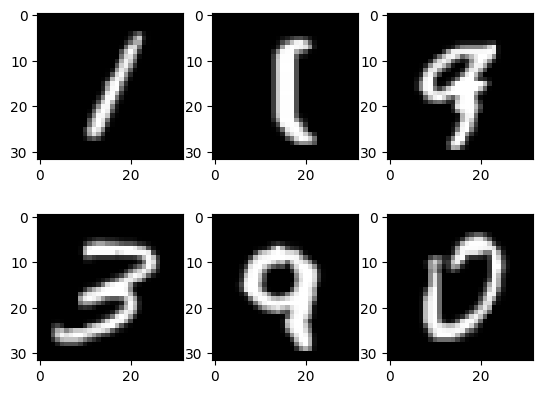

Predicted: "[1 1 9 3 9 0]", Actual: "[1 1 9 3 9 0]"


In [11]:

# 模型验证（使用生成的模型进行单个图片数据的分类预测）
import numpy as np
from mindspore import Tensor
import matplotlib.pyplot as plt

mnist = Mnist("./mnist", split="train", batch_size=6, resize=32)
dataset_infer = mnist.run()
ds_test = dataset_infer.create_dict_iterator()
data = next(ds_test)
images = data["image"].asnumpy()
labels = data["label"].asnumpy()

plt.figure()
for i in range(1, 7):
    plt.subplot(2, 3, i)
    plt.imshow(images[i-1][0], interpolation="None", cmap="gray")
plt.show()

# 使用函数model.predict预测image对应分类
output = model.predict(Tensor(data['image']))
predicted = np.argmax(output.asnumpy(), axis=1)

# 输出预测分类与实际分类
print(f'Predicted: "{predicted}", Actual: "{labels}"')